# Chapter 9: GANs and Adversarial Examples
A GAN is a framework that's used to generate new data by learning the distribution of data.

# Creating the dataset

### 1. Import the essential packages:

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms
import os

path_to_data = "./data/chapter_9"
os.makedirs(path_to_data, exist_ok=True)

### 2. Define the data transformations:

In [2]:
height, width = 64, 64
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
transform = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.CenterCrop((height, width)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

### 3. Instantiate an object of the STL-10 class:

In [3]:
train_dataset = datasets.STL10(path_to_data, split='train',
                          download=True,
                          transform=transform)
print(len(train_dataset))

Files already downloaded and verified
5000


### 4. Get a sample tensor from the dataset:

In [4]:
import torch
for x, _ in train_dataset:
    print(x.shape, torch.min(x), torch.max(x))
    break

torch.Size([3, 64, 64]) tensor(-0.8980) tensor(0.9529)


### 5. Let's display the sample tensor:

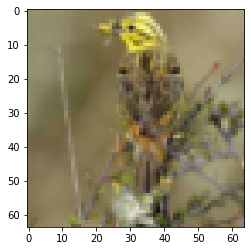

In [5]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

plt.imshow(to_pil_image(0.5*x + 0.5))

### 6. Create the dataloader:

In [6]:
import torch

batch_size = 32
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=batch_size,
                                                shuffle=True)

###  7. Get a data batch from the dataloader

In [7]:
for x, y in train_data_loader:
    print(x.shape, y.shape)
    break

torch.Size([32, 3, 64, 64]) torch.Size([32])


## Defining the generator and discriminator

### 1. Define the Generator class:

In [8]:
from torch import nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, params):
        super(Generator, self).__init__()
        noise_vector = params["noise_vector"]
        num_conv_filters = params["num_conv_filters"]
        num_out_channels = params["num_out_channels"]
        
        self.dconv1 = nn.ConvTranspose2d(noise_vector, num_conv_filters * 8,
                                         kernel_size=4, stride=1,
                                         padding=0, bias=False)
        self.batch_norm_1 = nn.BatchNorm2d(num_conv_filters * 8)
        
        self.dconv2 = nn.ConvTranspose2d(num_conv_filters * 8,
                                         num_conv_filters * 4,
                                         kernel_size=4,
                                         stride=2,
                                         padding=1, bias=False)
        self.batch_norm_2 = nn.BatchNorm2d(num_conv_filters * 4)
        
        self.dconv3 = nn.ConvTranspose2d(num_conv_filters * 4,
                                         num_conv_filters * 2,
                                         kernel_size=4, stride=2,
                                         padding=1, bias=False)
        self.batch_norm_3 = nn.BatchNorm2d(num_conv_filters * 2)
        
        self.dconv4 = nn.ConvTranspose2d(num_conv_filters * 2,
                                         num_conv_filters,
                                         kernel_size=4, stride=2,
                                         padding=1, bias=False)
        self.batch_norm_4 = nn.BatchNorm2d(num_conv_filters)
        
        self.dconv5 = nn.ConvTranspose2d(num_conv_filters,
                                         num_out_channels,
                                         kernel_size=4,
                                         stride=2, padding=1,
                                         bias=False)
        
    def forward(self, x):
        x = F.relu(self.batch_norm_1(self.dconv1(x)))
        x = F.relu(self.batch_norm_2(self.dconv2(x)))
        x = F.relu(self.batch_norm_3(self.dconv3(x)))
        x = F.relu(self.batch_norm_4(self.dconv4(x)))
        out = torch.tanh(self.dconv5(x))
        return out

### 2. Define an object of the Generator class:

In [9]:
params_generator = {
    "noise_vector": 100,
    "num_conv_filters": 64,
    "num_out_channels": 3,
}
model_generator = Generator(params_generator)
device = torch.device("cuda")
model_generator.to(device)
print(model_generator)

Generator(
  (dconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch_norm_1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


### 3. Define the Discrinator class:

In [10]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super(Discriminator, self).__init__()
        num_in_channels = params["num_in_channels"]
        num_deconv_filters = params["num_deconv_filters"]
        
        self.conv1 = nn.Conv2d(num_in_channels, num_deconv_filters,
                               kernel_size=4, stride=2,
                               padding=1, bias=False)
        self.conv2 = nn.Conv2d(num_deconv_filters,
                               num_deconv_filters * 2, kernel_size=4,
                               stride=2, padding=1, bias=False)
        self.batch_norm_2 = nn.BatchNorm2d(num_deconv_filters * 2)
        
        self.conv3 = nn.Conv2d(num_deconv_filters * 2,
                               num_deconv_filters * 4, kernel_size=4,
                               stride=2, padding=1, bias=False)
        self.batch_norm_3 = nn.BatchNorm2d(num_deconv_filters * 4)
        
        self.conv4 = nn.Conv2d(num_deconv_filters * 4,
                               num_deconv_filters * 8,
                               kernel_size=4,
                               stride=2, padding=1, bias=False)
        self.batch_norm_4 = nn.BatchNorm2d(num_deconv_filters * 8)
        
        self.conv5 = nn.Conv2d(num_deconv_filters * 8, 1,
                               kernel_size=4,
                               stride=1, padding=0, bias=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.batch_norm_2(self.conv2(x)),
                         0.2, inplace=True)
        x = F.leaky_relu(self.batch_norm_3(self.conv3(x)),
                         0.2, inplace=True)
        x = F.leaky_relu(self.batch_norm_4(self.conv4(x)),
                         0.2, inplace=True)
        out = torch.sigmoid(self.conv5(x))
        return out.view(-1)

### 4. Define an object of the Discriminator class:

In [11]:
params_discriminator = {
    "num_in_channels": 3,
    "num_deconv_filters": 64
}

model_discriminator = Discriminator(params_discriminator)
model_discriminator.to(device)
print(model_discriminator)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm_4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


Let's pass some dummy input to the model:

In [12]:
with torch.no_grad():
    y = model_discriminator(torch.zeros(1, 3, height, width,
                                        device=device))

print(y.shape)

torch.Size([1])


### 5. Define a helper function to initialize the model weights:

In [13]:
def initialize_weights(model):
    classname = model.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

### 6. Initialize the model weights by calling the helper function:

In [14]:
model_generator.apply(initialize_weights);
model_discriminator.apply(initialize_weights);

## Defining the loss and optimizer

### 1. Define an object of the BCE loss class:

In [15]:
loss_function = nn.BCELoss()

### 2. Define the optimizer for the generator:

In [16]:
from torch import optim

lr = 2e-4
beta_1 = 0.5
optimizer_discriminator = optim.Adam(model_discriminator.parameters(),
                                     lr=lr,
                                     betas=(beta_1, 0.999))

### 3. Define the optimizer for the discriminator:

In [17]:
optimizer_generator = optim.Adam(model_generator.parameters(), 
                                 lr=lr,
                                 betas=(beta_1, 0.999))

## Training the models

Training the GAN framework is done in two stages: training the discriminator and training the generator. To this end, we will take the following steps:

1. Get a batch of real images with the target labels set to 1.
2. Generate a batch of fake images using the generator with the target labels set to 0.
3. Feed the mini-batches to the discriminator and compute the loss and gradients.
4. Update the discriminator parameters using the gradients.
5. Generate a batch of fake images using the generator with the target labels set to 1.
6. Feed the fake mini-batch to the discriminator and compute the loss and gradients.
7. Update the generator only based on gradients.
8. Repeat from step 1.

### 1. Define a few parameters:

In [18]:
real_label = 1
fake_label = 0
noise_vector = params_generator["noise_vector"]
num_epochs = 100

loss_history={"generator": [],
              "discriminator": []}

### 2. Start the training loop and calculate the loss for real samples:

In [22]:
batch_count = 0

for epoch in range(num_epochs):
    for x_batch, y_batch in train_data_loader:
        batch_size = x_batch.size(0)
        model_discriminator.zero_grad()
        x_batch = x_batch.to(device)
        y_batch = torch.full((batch_size,), real_label,
                             device=device)
        out_discriminator = model_discriminator(x_batch)
        loss_real = loss_function(out_discriminator, y_batch)
        loss_real.backward()
        
        # continue the training loop by calculating the loss for fake samples:

        noise = torch.randn(batch_size, noise_vector, 1, 1, device=device)
        out_generator = model_generator(noise)
        out_discriminator = model_discriminator(out_generator.detach())
        y_batch.fill_(fake_label)
        loss_fake = loss_function(out_discriminator, y_batch)
        loss_fake.backward()
        loss_discriminator = loss_real + loss_fake
        optimizer_discriminator.step()
        
        # continue the training loop
        model_generator.zero_grad()
        y_batch.fill_(real_label)
        out_discriminator = model_discriminator(out_generator)
        loss_generator = loss_function(out_discriminator, y_batch)
        loss_generator.backward()
        optimizer_generator.step()

        loss_history["generator"].append(loss_generator.item())
        loss_history["discriminator"].append(loss_discriminator.item())
        batch_count = batch_count + 1

        if batch_count % 100 == 0:
            print(epoch, loss_generator.item(), loss_discriminator.item())

0 11.111677169799805 0.7471572160720825
1 5.599127292633057 0.30035051703453064
1 2.3889269828796387 1.2347861528396606
2 8.6511869430542 1.1172200441360474
3 4.405440330505371 0.18246155977249146
3 7.03734016418457 0.35542353987693787
4 3.1067676544189453 0.3491009771823883
5 3.3666634559631348 0.400203138589859
5 3.6453700065612793 0.2646588087081909
6 3.020416021347046 0.6201850175857544
7 6.9462385177612305 0.6266788840293884
7 1.81218683719635 0.7813478708267212
8 3.7200841903686523 0.2953014671802521
8 3.864778995513916 0.26965099573135376
9 3.047415018081665 0.4537518620491028
10 5.6563310623168945 0.3209519386291504
10 3.6719002723693848 0.2751806974411011
11 3.6941652297973633 0.3544877767562866
12 4.09388542175293 0.33046215772628784
12 4.862166881561279 0.14322061836719513
13 5.359509468078613 0.4383048713207245
14 11.048657417297363 1.177587866783142
14 6.571467399597168 0.7603567242622375
15 4.930931091308594 0.3058546185493469
15 6.011255264282227 0.8566811680793762
16 3.

### 3. Plot the loss history:

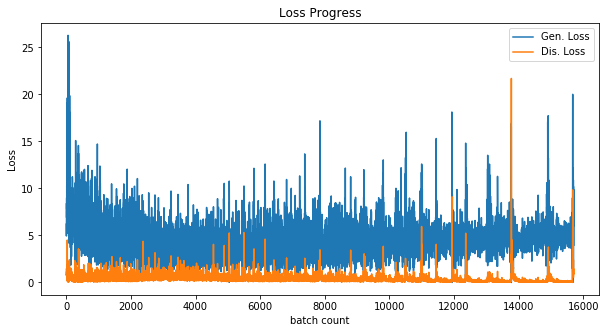

In [24]:
plt.figure(figsize=(10, 5))
plt.title("Loss Progress")
plt.plot(loss_history["generator"], label="Gen. Loss")
plt.plot(loss_history["discriminator"], label="Dis. Loss")
plt.xlabel("batch count")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 4. Store the model weights:

In [25]:
import os

path_to_models = "./models/"
os.makedirs(path_to_models, exist_ok=True)
path_to_weights_generator = os.path.join(path_to_models,
                                         "weights_generator.pt")
path_to_weights_discriminator = os.path.join(
                                    path_to_models,
                                    "weights_discriminator.pt")

torch.save(model_generator.state_dict(), path_to_weights_generator)
torch.save(model_discriminator.state_dict(),
           path_to_weights_discriminator)

## Deploying the generator

### 1. Load the weights

In [26]:
weights = torch.load(path_to_weights_generator)
model_generator.load_state_dict(weights)

<All keys matched successfully>

### 2. Set the model in evaluation mode: 

In [27]:
model_generator.eval()

Generator(
  (dconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch_norm_1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

### 3. Feed noise to the model and get its outputs:

In [28]:
with torch.no_grad():
    fixed_noise = torch.randn(16, noise_vector, 1, 1,
                              device=device)
    image_fake = model_generator(noise).detach().cpu()
print(image_fake.shape)

torch.Size([8, 3, 64, 64])


### 4. Display the generated images: 

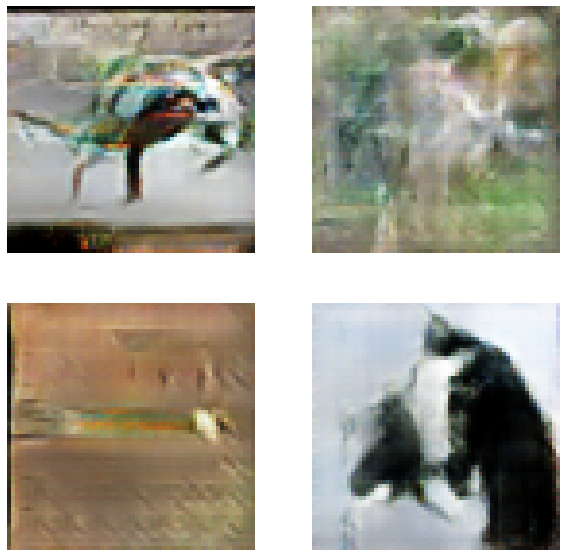

In [31]:
plt.figure(figsize=(10, 10))
for ii in range(4):
    plt.subplot(2, 2, ii+1)
    plt.imshow(to_pil_image(0.5 * image_fake[ii] + 0.5))
    plt.axis("off")

GANs perform better when they are trained with a single class.